In [210]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [211]:
# load mnist darta
dataset,  info = tfds.load("mnist", as_supervised=True, with_info=True)

In [212]:
dataset["train"]

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [213]:
num_train_example , num_test_examples = info.splits["train"].num_examples , info.splits["test"].num_examples

num_test_examples , num_train_example

(10000, 60000)

2025-06-18 16:38:11.278692: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


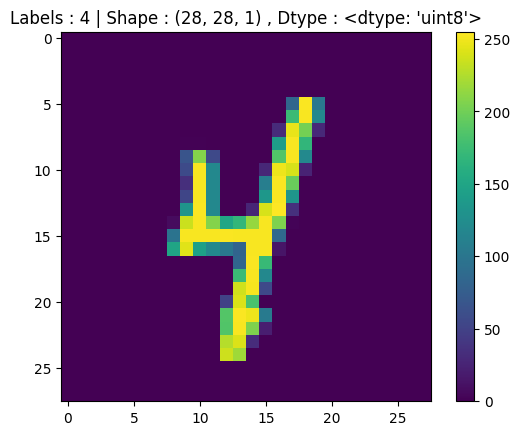

In [214]:
# mnist data
import matplotlib.pyplot as plt

for image, label in dataset["train"]:
    plt.imshow(image)
    plt.title(f"Labels : {label.numpy()} | Shape : {image.shape} , Dtype : {image.dtype}")
    plt.colorbar()
    break



In [215]:
# propoces the data - normalize, shuffle, batch, cache
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label    
    



In [216]:
mnist_train , mnist_test = dataset["train"], dataset["test"]

strategy = tf.distribute.MirroredStrategy()
strategy.num_replicas_in_sync

BATCH_IN_REPLICA = 64
BATCH_SIZE = BATCH_IN_REPLICA * strategy.num_replicas_in_sync
BATCH_SIZE

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


64

In [217]:
train_data = mnist_train.map(scale).cache().shuffle(10000).batch(BATCH_SIZE)
test_data = mnist_test.map(scale).batch(BATCH_SIZE)

In [218]:
next(iter(train_data))[0].shape

2025-06-18 16:38:11.685017: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-06-18 16:38:11.686348: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TensorShape([64, 28, 28, 1])

In [219]:
## model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(28,28,1)),  # 3  
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10)   # out :  (B,H,W,10)  inpu : (B,H,W,C)  ---> B,10
    ])# 1 dim 

In [220]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])

In [221]:
def decay(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >=3 and epoch <=7:
        return 1e-4
    else:
        return 1e-5

In [222]:
# callbcks - modelchekcpt, lr schduler, tensorbaord
import os
check_dir = "./checpoint-save"
check_dir_flag = os.path.join(check_dir, "train-ckpt-{epoch}.weights.h5")


In [223]:
tf.keras.callbacks.Callback.on_epoch_end

<function keras.src.callbacks.callback.Callback.on_epoch_end(self, epoch, logs=None)>

In [224]:
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch, logs=None):
            print('\nLearning rate for epoch {} is {}'.format( epoch + 1, model.optimizer.learning_rate.numpy()))
    




In [225]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="./new-log"),
    tf.keras.callbacks.ModelCheckpoint(save_weights_only=True, filepath=check_dir_flag, save_freq=2814),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [226]:
model.fit(train_data, epochs=15, callbacks=callbacks)

Epoch 1/15
929/938 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8845 - loss: 0.4024
Learning rate for epoch 1 is 0.0010000000474974513
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8851 - loss: 0.4003 - learning_rate: 0.0010
Epoch 2/15
932/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9784 - loss: 0.0755
Learning rate for epoch 2 is 0.0010000000474974513
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9784 - loss: 0.0754 - learning_rate: 0.0010
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9849 - loss: 0.0495
Learning rate for epoch 3 is 0.0010000000474974513
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9849 - loss: 0.0495 - learning_rate: 0.0010
Epoch 4/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9910 - loss: 0.0317
Learning rate for epoch 4 is 9.999999747378752e-05
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9910 - loss: 0.0317 - learning_rate: 1.0000e-04
Epoch 5/15
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

In [227]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [228]:
%tensorboard --logdir=new-log

Reusing TensorBoard on port 6007 (pid 51104), started 0:12:30 ago. (Use '!kill 51104' to kill it.)

In [229]:
938 * 64 # (1 batch)

60032

In [230]:
# 1epoch -- 60032

60032 * 3

180096

In [231]:
2000 /938

2.1321961620469083

In [232]:
938 * 3

2814

In [233]:
# weights only

model.load_weights


tf.keras.models.load_model()

<bound method Model.save of <Sequential name=sequential_11, built=True>>